In [7]:
# General
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import pytz
import seaborn as sns
from pandas.api.types import CategoricalDtype
import pickle

# Modelling
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras.layers import Dense
from keras.utils import to_categorical 
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight

# Geolocation libraries
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
from global_land_mask import globe

In [8]:
pd.set_option('display.max_columns', None)

## Information

This Notebook serves to further explore the use of metadata to support classification decisions at local taxonomic checkpoint, in order to aid in the classification of similar looking sympatric species, of which felids contain elements of both [1](https://onlinelibrary.wiley.com/doi/full/10.1002/ece3.5256), [2](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8035030/). The approach displayed promising results using the Proboscidia dataset, however this is a comparatively simple dataset, containing only three species, and 4 sub-species. The Felids dataset will provide a more relevant real-world dataset used to test the use of metadata in local taxonomic classification decisions.

Please note to use this notebook you will have to reconstruct `felid_data_cache/` directory to training the models using the `src/models/meta/model_training.py`

In [9]:
file_path = '../../data/obs_and_meta/processed/'

### Felids Observations

In [10]:
felids_df = pd.read_csv(file_path + 'felids_train.csv', index_col=0)

In [11]:
felids_df.head()

,observed_on,local_time_observed_at,latitude,longitude,positional_accuracy,public_positional_accuracy,image_url,license,geoprivacy,taxon_geoprivacy,scientific_name,common_name,taxon_id,taxon_kingdom_name,taxon_phylum_name,taxon_class_name,taxon_order_name,taxon_family_name,taxon_genus_name,taxon_species_name
id,,,,,,,,,,,,,,,,,,,,
3192,2009-08-16,2009-08-16 18:45:00-07:00,38.041290,-122.791489,NaN,NaN,https://inaturalist-open-data.s3.amazonaws.com...,CC0,NaN,open,Lynx rufus,Bobcat,41976,Animalia,Chordata,Mammalia,Carnivora,Felidae,Lynx,Lynx rufus
3424,2009-10-31,2009-10-31 17:24:00-07:00,37.856739,-121.767799,NaN,NaN,https://inaturalist-open-data.s3.amazonaws.com...,CC0,NaN,open,Lynx rufus,Bobcat,41976,Animalia,Chordata,Mammalia,Carnivora,Felidae,Lynx,Lynx rufus
3865,2009-12-06,2009-12-06 11:41:00-08:00,38.045437,-122.867188,NaN,NaN,https://inaturalist-open-data.s3.amazonaws.com...,CC0,NaN,open,Lynx rufus,Bobcat,41976,Animalia,Chordata,Mammalia,Carnivora,Felidae,Lynx,Lynx rufus
4125,2009-07-25,2009-07-26 07:27:00+02:00,-19.285032,23.535144,NaN,30580.0,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY-NC-ND,NaN,obscured,Panthera leo melanochaita,Southern Lion,557401,Animalia,Chordata,Mammalia,Carnivora,Felidae,Panthera,Panthera leo
5604,2010-02-18,2010-02-18 10:38:00-08:00,37.092007,-121.429604,NaN,NaN,https://inaturalist-open-data.s3.amazonaws.com...,NaN,NaN,open,Lynx rufus,Bobcat,41976,Animalia,Chordata,Mammalia,Carnivora,Felidae,Lynx,Lynx rufus


In [12]:
print("Shape: ", felids_df.shape)
print("Columns: ", felids_df.columns)

Shape:  (64536, 20)
Columns:  Index(['observed_on', 'local_time_observed_at', 'latitude', 'longitude',
       'positional_accuracy', 'public_positional_accuracy', 'image_url',
       'license', 'geoprivacy', 'taxon_geoprivacy', 'scientific_name',
       'common_name', 'taxon_id', 'taxon_kingdom_name', 'taxon_phylum_name',
       'taxon_class_name', 'taxon_order_name', 'taxon_family_name',
       'taxon_genus_name', 'taxon_species_name'],
      dtype='object')


### Felids Meta

In [13]:
meta_df = pd.read_csv(file_path + 'felids_meta.csv', index_col=0)

In [14]:
meta_df.head()

,lat,long,observed_on,time_zone,elevation,time,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,surface_pressure,precipitation,rain,snowfall,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,et0_fao_evapotranspiration_hourly,weathercode_hourly,vapor_pressure_deficit,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,weathercode_daily,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,sunrise,sunset,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration_daily
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
3192,38.041290,-122.791489,2009-08-16 18:45:00-07:00,America/Los_Angeles,14.0,2009-08-16T18:00,19.8,64.0,12.8,18.4,1004.1,0.0,0.0,0.0,2.0,2.0,0.0,0.0,432.0,335.0,97.0,16.3,22.1,275.0,286.0,27.0,0.26,0,0.84,23.8,20.0,17.7,0.148,0.164,0.215,1,21.0,13.0,21.6,12.7,0.0,0.0,0.0,0.0,2009-08-16T06:26,2009-08-16T20:04,16.6,27.4,270.0,25.74,4.20
3424,37.856739,-121.767799,2009-10-31 17:24:00-07:00,America/Los_Angeles,224.0,2009-10-31T17:00,19.6,64.0,12.5,19.8,991.7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,256.0,196.0,60.0,4.5,6.8,299.0,295.0,15.5,0.14,0,0.83,19.4,15.9,17.0,0.225,0.263,0.186,0,19.9,8.9,19.9,8.0,0.0,0.0,0.0,0.0,2009-10-31T07:30,2009-10-31T18:10,7.5,19.8,247.0,13.68,2.09
3865,38.045437,-122.867188,2009-12-06 11:41:00-08:00,America/Los_Angeles,54.0,2009-12-06T11:00,7.7,65.0,1.6,2.4,1003.0,0.0,0.0,0.0,37.0,41.0,1.0,0.0,260.0,186.0,74.0,23.7,30.4,296.0,296.0,45.7,0.12,1,0.37,8.3,8.7,12.0,0.254,0.259,0.224,51,8.9,4.7,6.7,2.1,0.7,0.7,0.0,2.0,2009-12-06T08:12,2009-12-06T17:53,23.7,45.7,277.0,8.12,1.16
4125,-19.285032,23.535144,2009-07-26 07:27:00+02:00,Africa/Gaborone,945.0,2009-07-26T07:00,9.6,76.0,5.5,6.5,917.5,0.0,0.0,0.0,47.0,15.0,55.0,0.0,0.0,0.0,0.0,13.9,26.9,115.0,110.0,24.8,0.02,1,0.29,10.9,16.4,19.1,0.051,0.081,0.101,1,21.2,9.6,17.4,6.5,0.0,0.0,0.0,0.0,2009-07-26T06:55,2009-07-26T18:09,17.3,34.9,111.0,14.89,3.55
5604,37.092007,-121.429604,2010-02-18 10:38:00-08:00,America/Los_Angeles,786.0,2010-02-18T10:00,10.8,89.0,9.1,10.5,947.6,0.0,0.0,0.0,30.0,1.0,0.0,96.0,205.0,122.0,83.0,0.4,0.4,270.0,90.0,10.8,0.09,1,0.14,11.7,10.3,10.6,0.337,0.350,0.365,3,16.4,5.8,16.0,4.5,0.0,0.0,0.0,0.0,2010-02-18T07:49,2010-02-18T18:50,6.4,19.8,238.0,14.39,2.12


In [15]:
print("Shape: ", meta_df.shape)
print("Columns: ", meta_df.columns)

Shape:  (68069, 51)
Columns:  Index(['lat', 'long', 'observed_on', 'time_zone', 'elevation', 'time',
       'temperature_2m', 'relativehumidity_2m', 'dewpoint_2m',
       'apparent_temperature', 'surface_pressure', 'precipitation', 'rain',
       'snowfall', 'cloudcover', 'cloudcover_low', 'cloudcover_mid',
       'cloudcover_high', 'shortwave_radiation', 'direct_radiation',
       'diffuse_radiation', 'windspeed_10m', 'windspeed_100m',
       'winddirection_10m', 'winddirection_100m', 'windgusts_10m',
       'et0_fao_evapotranspiration_hourly', 'weathercode_hourly',
       'vapor_pressure_deficit', 'soil_temperature_0_to_7cm',
       'soil_temperature_7_to_28cm', 'soil_temperature_28_to_100cm',
       'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm',
       'soil_moisture_28_to_100cm', 'weathercode_daily', 'temperature_2m_max',
       'temperature_2m_min', 'apparent_temperature_max',
       'apparent_temperature_min', 'precipitation_sum', 'rain_sum',
       'snowfall_sum', 'precipi

## Data Merging

In [16]:
def aggregate_data(observation_file: str, meta_file: str) -> pd.DataFrame:
    obs_df = pd.read_csv(file_path + observation_file, index_col=0)
    meta_df = pd.read_csv(file_path + meta_file, index_col=0)

    obs_df = obs_df.drop(columns=['observed_on', 'local_time_observed_at', 'positional_accuracy'])
    meta_df = meta_df.drop(columns=['lat', 'long', 'time'])

    df = pd.merge(obs_df, meta_df, how='inner', left_index=True, right_index=True)
    return df

In [17]:
df = aggregate_data('felids_train.csv', 'felids_meta.csv')

### Brief Analysis

#### Null Values

In [18]:
df.columns[df.isnull().any()].tolist()

['public_positional_accuracy',
 'license',
 'geoprivacy',
 'taxon_geoprivacy',
 'taxon_species_name']

##### Taxon Species Name Null Values

In [19]:
df[df['taxon_species_name'].isnull()].head()

,latitude,longitude,public_positional_accuracy,image_url,license,geoprivacy,taxon_geoprivacy,scientific_name,common_name,taxon_id,taxon_kingdom_name,taxon_phylum_name,taxon_class_name,taxon_order_name,taxon_family_name,taxon_genus_name,taxon_species_name,observed_on,time_zone,elevation,temperature_2m,relativehumidity_2m,dewpoint_2m,apparent_temperature,surface_pressure,precipitation,rain,snowfall,cloudcover,cloudcover_low,cloudcover_mid,cloudcover_high,shortwave_radiation,direct_radiation,diffuse_radiation,windspeed_10m,windspeed_100m,winddirection_10m,winddirection_100m,windgusts_10m,et0_fao_evapotranspiration_hourly,weathercode_hourly,vapor_pressure_deficit,soil_temperature_0_to_7cm,soil_temperature_7_to_28cm,soil_temperature_28_to_100cm,soil_moisture_0_to_7cm,soil_moisture_7_to_28cm,soil_moisture_28_to_100cm,weathercode_daily,temperature_2m_max,temperature_2m_min,apparent_temperature_max,apparent_temperature_min,precipitation_sum,rain_sum,snowfall_sum,precipitation_hours,sunrise,sunset,windspeed_10m_max,windgusts_10m_max,winddirection_10m_dominant,shortwave_radiation_sum,et0_fao_evapotranspiration_daily
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
4384974,-25.370169,31.904725,15.0,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY-NC,NaN,obscured,Felis,Palearctic and African Small Cats,41956,Animalia,Chordata,Mammalia,Carnivora,Felidae,Felis,NaN,2016-10-01 20:23:00+02:00,Africa/Johannesburg,196.0,21.4,73.0,16.4,22.0,988.3,0.0,0.0,0.0,26.0,9.0,7.0,44.0,0.0,0.0,0.0,10.9,20.9,117.0,117.0,20.9,0.03,1,0.68,22.8,23.9,24.8,0.210,0.167,0.165,55,23.2,18.3,24.2,18.1,3.1,3.1,0.0,4.0,2016-10-01T05:30,2016-10-01T17:53,18.8,38.2,155.0,7.07,1.87
8267688,42.695880,-4.003257,1032.0,https://static.inaturalist.org/photos/10966456...,NaN,NaN,open,Felis,Palearctic and African Small Cats,41956,Animalia,Chordata,Mammalia,Carnivora,Felidae,Felis,NaN,2017-08-08 12:34:00+02:00,Europe/Madrid,907.0,16.8,49.0,6.0,14.3,909.7,0.0,0.0,0.0,32.0,32.0,5.0,0.0,591.0,448.0,143.0,11.6,15.0,353.0,350.0,32.8,0.35,1,0.98,21.0,19.4,19.7,0.137,0.151,0.172,51,20.2,10.6,17.4,9.4,0.3,0.3,0.0,2.0,2017-08-08T07:13,2017-08-08T21:29,19.1,41.0,18.0,20.87,3.93
38614655,38.555909,16.314833,8.0,https://static.inaturalist.org/photos/60826828...,CC-BY,NaN,open,Felis catus × silvestris,Domestic × European Wildcat,928537,Animalia,Chordata,Mammalia,Carnivora,Felidae,Felis,NaN,2018-09-07 22:30:00+02:00,Europe/Rome,831.0,19.0,94.0,18.0,20.0,928.0,0.3,0.3,0.0,27.0,23.0,10.0,2.0,0.0,0.0,0.0,13.0,19.7,298.0,301.0,33.1,0.00,51,0.13,21.3,22.5,21.1,0.201,0.228,0.208,51,25.4,18.4,27.2,19.7,1.0,1.0,0.0,4.0,2018-09-07T06:27,2018-09-07T19:17,15.7,36.7,300.0,19.14,3.76
39238484,-26.020148,-48.754332,404.0,https://inaturalist-open-data.s3.amazonaws.com...,CC-BY-NC,NaN,NaN,Leopardus,American Small Cats,41986,Animalia,Chordata,Mammalia,Carnivora,Felidae,Leopardus,NaN,2020-02-24 15:28:00-03:00,America/Sao_Paulo,13.0,25.8,67.0,19.2,27.7,1010.2,0.0,0.0,0.0,65.0,56.0,25.0,0.0,444.0,246.0,198.0,10.8,12.9,53.0,54.0,30.2,0.33,2,1.11,25.1,22.6,23.5,0.422,0.426,0.430,51,26.0,18.8,28.5,21.2,1.0,1.0,0.0,5.0,2020-02-24T06:04,2020-02-24T18:51,14.7,30.2,33.0,16.59,3.38
41329698,37.199774,22.543176,117631.0,https://static.inaturalist.org/photos/65554318...,NaN,NaN,NaN,Felis catus × silvestris,Domestic × European Wildcat,928537,Animalia,Chordata,Mammalia,Carnivora,Felidae,Felis,NaN,2020-04-01 18:59:00+03:00,Europe/Athens,1043.0,9.8,64.0,3.3,7.3,891.9,0.3,0.3,0.0,39.0,15.0,42.0,1.0,315.0,189.0,126.0,6.4,10.2,243.0,247.0,35.3,0.16,51,0.44,12.5,10.0,8.7,0.359,0.359,0.320,53,11.5,4.1,9.3,1.6,3.9,3.9,0.0,13.0,2020-04-01T07:13,2020-04-01T19:53,10.0,40.7,249.0,18.39,2.55


These null values are indicative of cross species, and generally inconsistent observations. They can be dropped due to their relatively small size. This dropping is already handled in the pipeline.

##### Public Positional Values Null Values

In [20]:
df[df['public_positional_accuracy'].isnull()].shape

(6805, 65)

This is a signficiant quantity of data, however the accuracy is unknown and could introduce incorrect data into the models, hence the Null values are still dropped. 90% of the dataset is still retained.

## Felid Taxonomy Exploration

The **Kingdom**, **Class**, **Order**, and **Family** are all the same for Felids, differentiation comes in the taxonomic levels of **Genus**, **Species**, and **Sub-species**.

A seperate dataset, and notebook will be used to test the **Kingdom**, **Class**, **Order**, and **Family** meta-data capability.

Note, that models utilize the metadata's variance in order to correctly classify taxonomic rank correctly. However during this process it was noted that for non-wildlife species (domesticated) such as the common cat (Felis catus), this inhibits model training as it encompasses global locations which in turn generalizes to encompassing all model variance.

In [21]:
# Domesticated wildlife restriction restriction
df = df[df['taxon_species_name'] != 'Felis catus'].copy()

### Genus

It is expected for the Genus classification to perform poorly, due to the high variance contained within each Genus. It is expected that as the taxomomic order decreases, the accuracy of the models is expected to increase. 

Note, as the taxomoc order decreases, we do not attempt to classify all mammals at the species level, but rather classify all of the species within a particular genus.

In [22]:
genus_counts = df['taxon_genus_name'].value_counts()
print(genus_counts)

Lynx            18171
Panthera        11385
Puma             4847
Leopardus        1995
Acinonyx         1690
Felis             902
Caracal           540
Leptailurus       402
Herpailurus       393
Prionailurus      273
Neofelis           23
Otocolobus         18
Pardofelis          9
Catopuma            5
Name: taxon_genus_name, dtype: int64


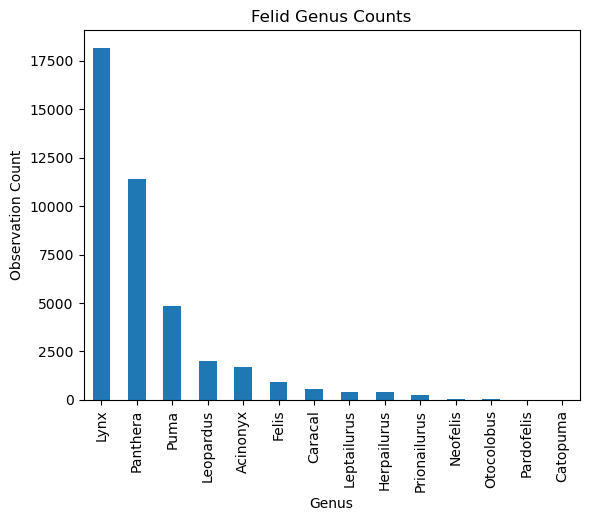

In [23]:
genus_counts.plot(kind='bar')

plt.title('Felid Genus Counts')
plt.xlabel('Genus')
plt.ylabel('Observation Count')
plt.show()

#### Geographic Distribution

/tmp/ipykernel_137969/2325543736.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


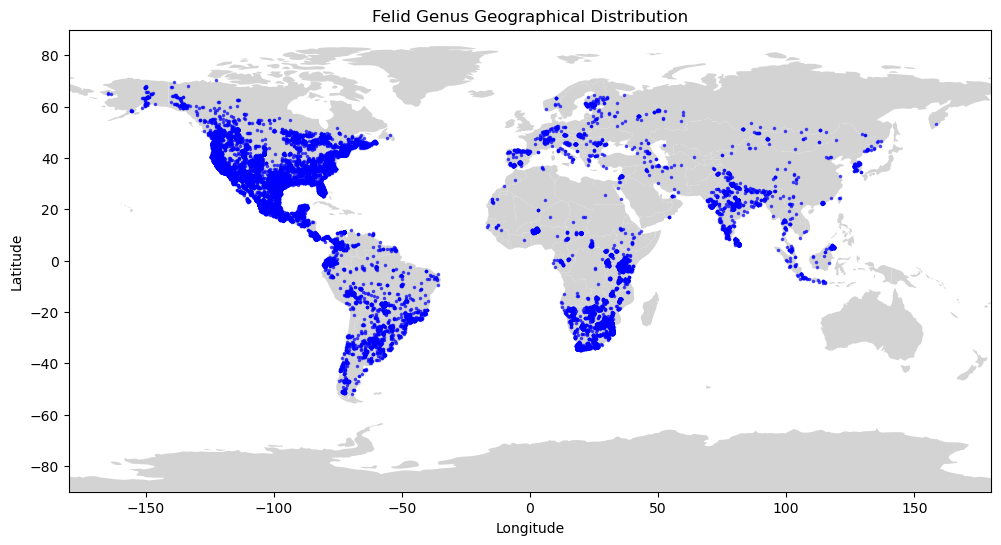

In [24]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)

x = df['longitude']
y = df['latitude']

scatter = plt.scatter(x, y, s=2.5, alpha=0.6, c='blue')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Felid Genus Geographical Distribution")

plt.show()

#### KMeans

This method will require automation in order to determine the optimal number of centroids, but for this test set purpose manual inspection is sufficient

In [25]:
location_df = df[['latitude', 'longitude']]

In [26]:
location_matrix = location_df.to_numpy()

In [27]:
def calculate_optimal_k(data, k_max, interval, k_init):
    ssw = []
    
    k = k_init
    while k <= k_max:
        k_means = KMeans(n_clusters=k,  n_init=10).fit(data)
        centroids = k_means.cluster_centers_
        predicted_clusters = k_means.predict(data)
        sse = 0
        
        # Calculate distance from each point to cluster center. This is accumulated to be the SSW
        for locat in range(len(data)):
            centroid = centroids[predicted_clusters[locat]]
            sse += (data[locat, 0] - centroid[0]) ** 2 + (data[locat, 1] - centroid[1]) ** 2
            
        ssw.append(sse)
        
        k += interval
    return ssw

In [28]:
k_max = 500
interval = 20
k_init = 10

kmeans_ssw = calculate_optimal_k(location_matrix, k_max, interval, k_init)

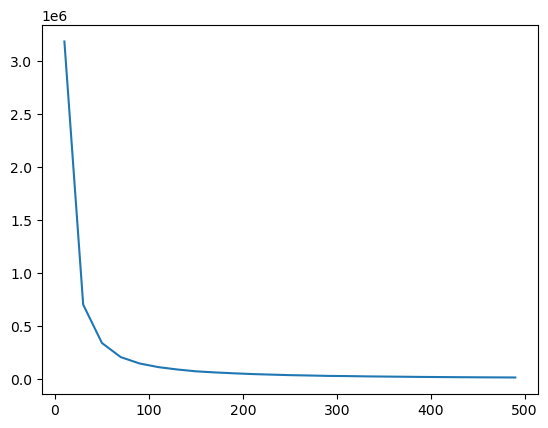

In [29]:
plt.plot(range(k_init, k_max, interval), kmeans_ssw)
plt.show()

In [30]:
k_means = KMeans(n_clusters=60, n_init=10)
k_means.fit(location_matrix)
clusters = k_means.cluster_centers_

#### Model Accuracies

Note the models are trained within `src/models` and the results displayed here for discussion.

Both models utilize **class weighting** based on the dataset.

##### Decision Tree
The decision tree is trained using 10-fold cross validation to assess the optimal depth of the tree and to determine the model's accuracy on felid genus. The metric of accuracy is balanced_accuracy which will give an accurate measure of model accuracy despite unbalanced dataset. 

##### Neural Network
The neural netwrok is trained using 5-fold cross validation, on a simple densely connected neural network. 
The metric of accuracy used is Categorical Accuracy and the loss function is categorical cross entropy. 

##### Decision Tree

In [31]:
dt_genus_training_accuracy = pd.read_csv('felid_data_cache/felid_genus_dt_training_accuracy.csv')

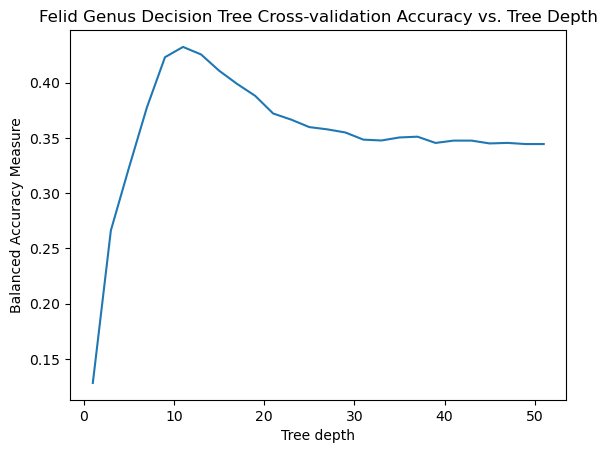

In [32]:
plt.plot(dt_genus_training_accuracy['depth'], 
         dt_genus_training_accuracy['mean_scores'], label='balanced accuracy')

plt.title('Felid Genus Decision Tree Cross-validation Accuracy vs. Tree Depth')
plt.xlabel('Tree depth')
plt.ylabel('Balanced Accuracy Measure')
plt.show()

The model training accuracy peaks at 40% accuracy at an approximate depth of 12. Howere due to the training imbalance this is not a sufficient measure of the model's capability. The Confusion matrix on a validation set is shown below.

Load the trained decision tree model

In [33]:
dt_felid_genus_model = pickle.load(open('felid_data_cache/felid_genus_dt_model.sav', 'rb'))

/home/travisdawson/anaconda3/envs/data_analysis/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.0 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Prep the validation set data, for confusion matrix construction

In [34]:
def prep_dt_validationSet(df:pd.DataFrame, taxon_target:str):
    taxon_y = df[taxon_target]
    
    if taxon_y.isnull().any():
        df = df.dropna(subset=[taxon_target])
    
    y = df[taxon_target]
    X = df.drop(columns=['taxon_kingdom_name', 'taxon_phylum_name',
                             'taxon_class_name', 'taxon_order_name', 'taxon_family_name',
                             'taxon_genus_name', 'taxon_species_name', 'sub_species', 'common_name'])

    return X, y

Load the validation set

In [35]:
dt_genus_df_val = pd.read_csv('felid_data_cache/felid_genus_dt_validation.csv', index_col=0)

In [36]:
dt_genus_df_val.head()

,apparent_temperature,apparent_temperature_max,apparent_temperature_min,cloudcover,cloudcover_high,cloudcover_low,cloudcover_mid,common_name,dewpoint_2m,diffuse_radiation,direct_radiation,elevation,et0_fao_evapotranspiration_daily,et0_fao_evapotranspiration_hourly,precipitation,precipitation_hours,precipitation_sum,rain,rain_sum,relativehumidity_2m,shortwave_radiation,shortwave_radiation_sum,snowfall,snowfall_sum,soil_moisture_0_to_7cm,soil_moisture_28_to_100cm,soil_moisture_7_to_28cm,soil_temperature_0_to_7cm,soil_temperature_28_to_100cm,soil_temperature_7_to_28cm,sub_species,surface_pressure,taxon_class_name,taxon_family_name,taxon_genus_name,taxon_kingdom_name,taxon_order_name,taxon_phylum_name,taxon_species_name,temperature_2m,temperature_2m_max,temperature_2m_min,vapor_pressure_deficit,weathercode_daily,weathercode_hourly,winddirection_100m,winddirection_10m,winddirection_10m_dominant,windgusts_10m,windgusts_10m_max,windspeed_100m,windspeed_10m,windspeed_10m_max,location_cluster,land,hemisphere,month,hour,light,szn_Spring,szn_Summer,szn_Autumn
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
148138741,30.6,33.8,20.7,6.0,0.0,5.0,2.0,Southern Cheetah,13.6,129.0,741.0,1212.0,5.33,0.63,0.0,7.0,2.2,0.0,2.2,42.0,870.0,24.67,0.0,0.0,0.117,0.156,0.147,38.4,28.3,30.0,Acinonyx jubatus jubatus,890.5,Mammalia,Felidae,Acinonyx,Animalia,Carnivora,Chordata,Acinonyx jubatus,27.7,31.5,19.8,2.15,53,0,98.0,90.0,176.0,21.2,34.9,2.5,2.2,8.0,0,1,0,10,11,1,1,0,0
6468552,27.8,36.7,18.8,0.0,0.0,0.0,0.0,Northwest African Cheetah,-3.9,0.0,0.0,248.0,8.74,0.15,0.0,0.0,0.0,0.0,0.0,10.0,0.0,23.90,0.0,0.0,0.089,0.136,0.128,33.4,30.8,33.3,Acinonyx jubatus hecki,980.3,Mammalia,Felidae,Acinonyx,Animalia,Carnivora,Chordata,Acinonyx jubatus,31.7,39.5,23.5,4.22,1,0,57.0,52.0,69.0,15.1,40.7,22.7,8.7,18.8,11,1,1,2,21,0,0,0,0
5687513,15.7,29.7,15.4,1.0,0.0,0.0,2.0,Southern Cheetah,12.7,4.0,3.0,973.0,4.63,0.03,0.0,0.0,0.0,0.0,0.0,80.0,7.0,20.29,0.0,0.0,0.072,0.181,0.103,16.8,24.0,22.4,Acinonyx jubatus jubatus,904.6,Mammalia,Felidae,Acinonyx,Animalia,Carnivora,Chordata,Acinonyx jubatus,16.2,28.8,15.8,0.37,0,0,79.0,88.0,54.0,15.5,33.8,23.5,9.4,13.5,18,1,0,4,7,1,0,0,1
101923515,21.1,21.8,5.4,0.0,0.0,0.0,0.0,Southern Cheetah,5.6,106.0,556.0,535.0,3.11,0.43,0.0,0.0,0.0,0.0,0.0,33.0,662.0,15.35,0.0,0.0,0.109,0.154,0.146,25.3,21.6,17.9,Acinonyx jubatus jubatus,966.0,Mammalia,Felidae,Acinonyx,Animalia,Carnivora,Chordata,Acinonyx jubatus,22.5,23.7,7.1,1.81,0,0,360.0,360.0,57.0,21.2,24.8,7.9,6.8,9.7,5,1,0,6,12,1,0,0,0
118903701,35.0,38.6,21.6,7.0,0.0,0.0,11.0,Southern Cheetah,16.3,74.0,332.0,448.0,6.11,0.32,0.0,0.0,0.0,0.0,0.0,36.0,406.0,27.45,0.0,0.0,0.134,0.156,0.164,37.6,27.8,30.4,Acinonyx jubatus jubatus,957.3,Mammalia,Felidae,Acinonyx,Animalia,Carnivora,Chordata,Acinonyx jubatus,33.5,33.8,19.9,3.32,0,0,30.0,32.0,70.0,14.4,18.7,5.8,4.7,8.7,5,1,0,2,17,1,0,1,0


In [37]:
X_val, y_val = prep_dt_validationSet(dt_genus_df_val, 'taxon_genus_name')

In [38]:
y_pred = dt_felid_genus_model.predict(X_val)

In [39]:
cm = confusion_matrix(y_val, y_pred)

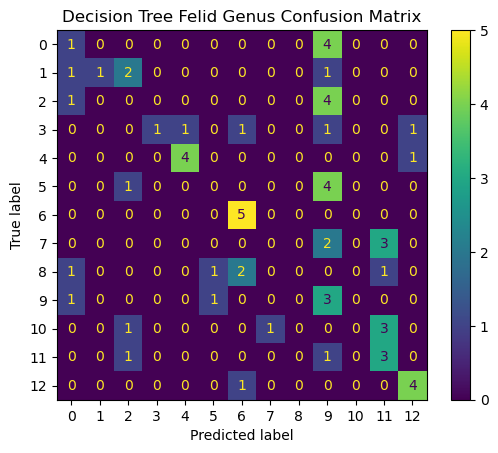

In [40]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.title('Decision Tree Felid Genus Confusion Matrix')
plt.show()

##### Neural Network

In [41]:
nn_genus_training_accuracy = pd.read_csv('felid_data_cache/felid_genus_nn_training_accuracy.csv')

In [42]:
nn_genus_training_accuracy = nn_genus_training_accuracy.T

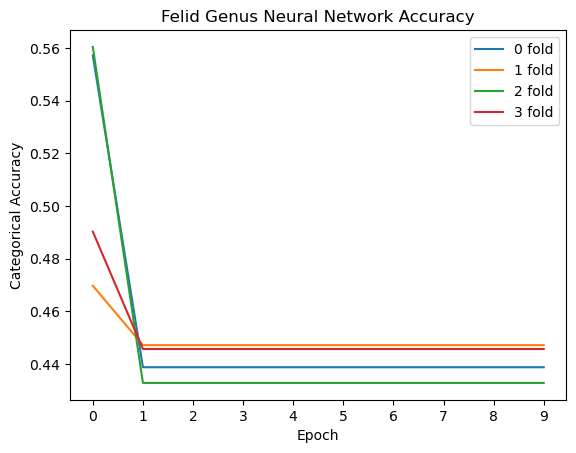

In [43]:
for i in range(nn_genus_training_accuracy.shape[1]):
    plt.plot(nn_genus_training_accuracy[i], label=(str(i) + ' fold'))

    
plt.title('Felid Genus Neural Network Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()

For an unknown reason this model experiences over-training, hence the decreasing model training accuracy over epochs. This error did not occur previosly, and will need to be looked into. However, all species and sub-species models are run using the same framework, and produce models as expected. Additionall, class weighting produces abysmal accuracies. 

Load the trained model

In [44]:
nn_felid_genus_model = keras.models.load_model('felid_data_cache/felid_genus_nn_model')

2023-06-15 20:30:37.789316: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-06-15 20:30:37.852645: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [45]:
def prep_nn_validationSet(df:pd.DataFrame, taxon_target:str):
    taxon_y = df[taxon_target]
    
    if taxon_y.isnull().any():
        df = df.dropna(subset=[taxon_target])
    
    y = df[taxon_target]
    X = df.drop(columns=['taxon_kingdom_name', 'taxon_phylum_name',
                             'taxon_class_name', 'taxon_order_name', 'taxon_family_name',
                             'taxon_genus_name', 'taxon_species_name', 'sub_species', 'common_name'])
    # Encode labels
    classes = y.nunique()
    lb = LabelBinarizer()
    lb.fit(y)
    y = lb.transform(y)
    
    
    # Normalize numerical columns in the dataset
    norm_columns = ['apparent_temperature', 'apparent_temperature_max', 'apparent_temperature_min',
                    'cloudcover', 'cloudcover_high', 'cloudcover_low', 'cloudcover_mid', 'dewpoint_2m',
                    'diffuse_radiation', 'direct_radiation', 'elevation', 'et0_fao_evapotranspiration_daily',
                    'et0_fao_evapotranspiration_hourly', 'precipitation', 'precipitation_hours',
                    'precipitation_sum', 'rain', 'rain_sum', 'relativehumidity_2m', 'shortwave_radiation',
                    'shortwave_radiation_sum', 'snowfall', 'snowfall_sum', 'soil_moisture_0_to_7cm',
                    'soil_moisture_28_to_100cm', 'soil_moisture_7_to_28cm', 'soil_temperature_0_to_7cm',
                    'soil_temperature_28_to_100cm', 'soil_temperature_7_to_28cm', 'surface_pressure',
                    'temperature_2m', 'temperature_2m_max', 'temperature_2m_min', 'vapor_pressure_deficit',
                    'winddirection_100m', 'winddirection_10m', 'winddirection_10m_dominant',
                    'windgusts_10m', 'windgusts_10m_max', 'windspeed_100m', 'windspeed_10m',
                    'windspeed_10m_max']

    X[norm_columns] = StandardScaler().fit_transform(X[norm_columns])
    return X, y, lb

Load the validation set

In [46]:
nn_genus_df_val = pd.read_csv('felid_data_cache/felid_genus_nn_validation.csv', index_col=0)

In [47]:
X_val, y_val, lb = prep_nn_validationSet(nn_genus_df_val, 'taxon_genus_name')

In [48]:
y_pred = np.argmax(nn_felid_genus_model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)

3/3 [==============================] - 0s 2ms/step


In [49]:
cm = confusion_matrix(y_true, y_pred)

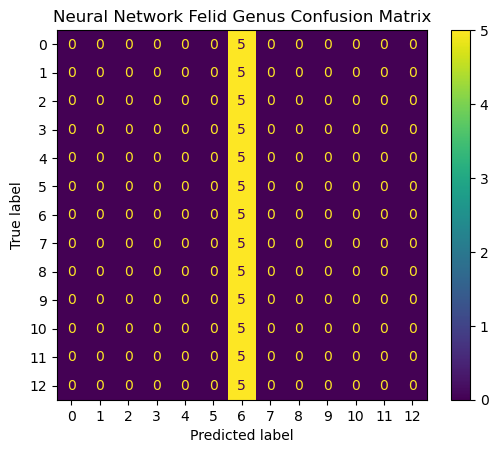

In [50]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.title('Neural Network Felid Genus Confusion Matrix')
plt.show()

## Species

Based on the Genus bar plot, we will explore species classification within two Genus taxonomies, representing the spread of the Felid Genus types, ranging from large observation counts in *Lynx* to small observation counts in *Caracal*

### Lynx

In [51]:
lynx_df = df[df['taxon_genus_name'] == 'Lynx']

In [52]:
lynx_counts = lynx_df['taxon_species_name'].value_counts()
print(lynx_counts)

Lynx rufus         17150
Lynx canadensis      667
Lynx lynx            252
Lynx pardinus        102
Name: taxon_species_name, dtype: int64


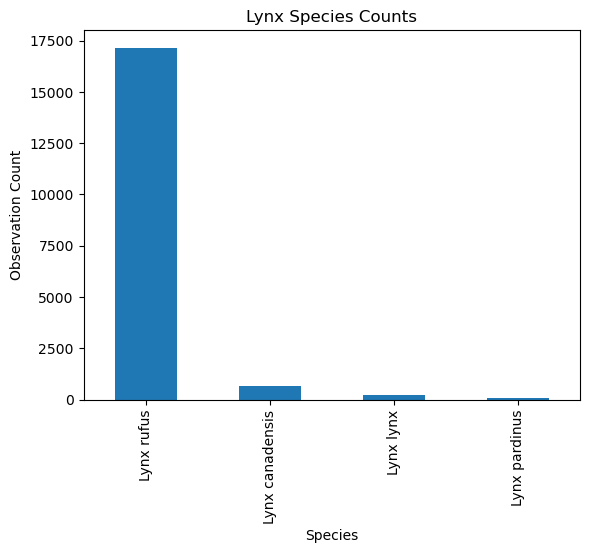

In [53]:
lynx_counts.plot(kind='bar')

plt.title('Lynx Species Counts')
plt.xlabel('Species')
plt.ylabel('Observation Count')
plt.show()

#### Geographic Distribution for K-means re-training

/tmp/ipykernel_137969/4111793887.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


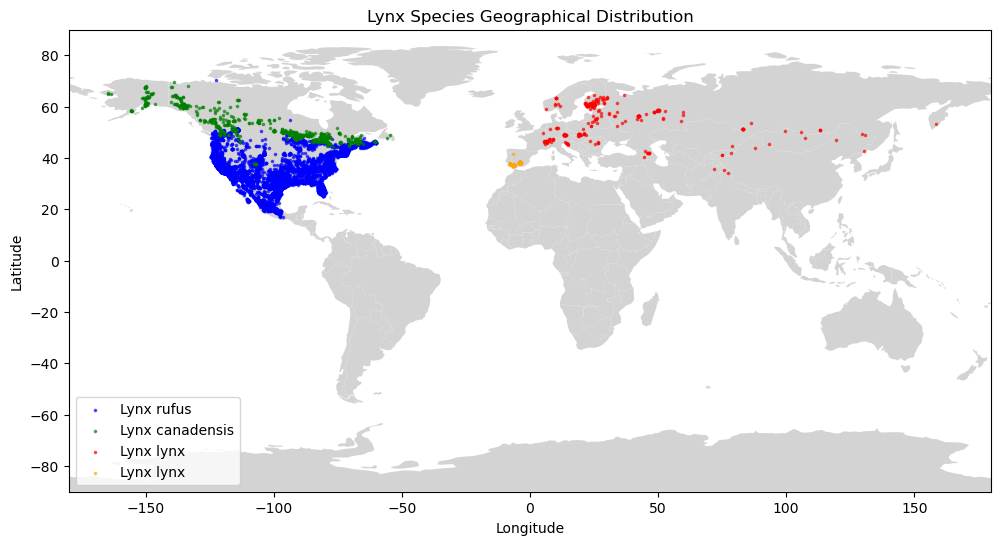

In [54]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)


# Lynx rufus
rufus_df = lynx_df[lynx_df['taxon_species_name'] == 'Lynx rufus']
rufus_x = rufus_df['longitude']
rufus_y = rufus_df['latitude']

# Lynx canadensis
canadensis_df = lynx_df[lynx_df['taxon_species_name'] == 'Lynx canadensis']
canadensis_x = canadensis_df['longitude']
canadensis_y = canadensis_df['latitude']

# Lynx lynx
lyn_df = lynx_df[lynx_df['taxon_species_name'] == 'Lynx lynx']
lyn_x = lyn_df['longitude']
lyn_y = lyn_df['latitude']

# Lynx pardinus
pardinus_df = df[df['taxon_species_name'] == 'Lynx pardinus']
pardinus_x = pardinus_df['longitude']
pardinus_y = pardinus_df['latitude']

# Scatter plots
scatter = plt.scatter(rufus_x, rufus_y, s=2.5, alpha=0.6, c='blue', label='Lynx rufus')
scatter = plt.scatter(canadensis_x, canadensis_y, s=2.5, alpha=0.6, c='green', label='Lynx canadensis')
scatter = plt.scatter(lyn_x, lyn_y, s=2.5, alpha=0.6, c='red', label='Lynx lynx')
scatter = plt.scatter(pardinus_x, pardinus_y, s=2.5, alpha=0.6, c='orange', label='Lynx lynx')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Lynx Species Geographical Distribution")

plt.legend()
plt.show()

#### Decision Tree

In [55]:
dt_lynx_species_training_accuracy = pd.read_csv('felid_data_cache/lynx_species_dt_training_accuracy.csv')

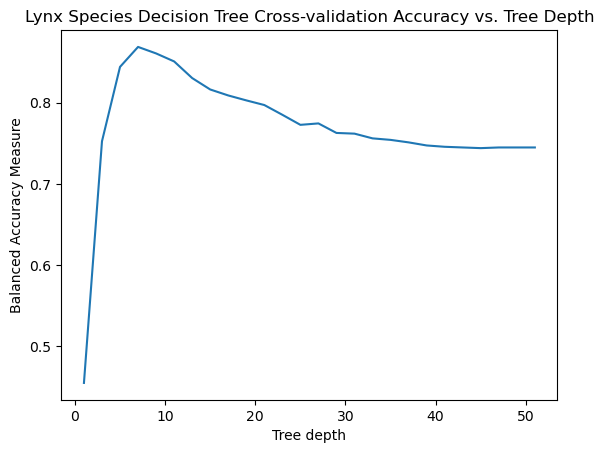

In [56]:
plt.plot(dt_lynx_species_training_accuracy['depth'], 
         dt_lynx_species_training_accuracy['mean_scores'], label='balanced accuracy')

plt.title('Lynx Species Decision Tree Cross-validation Accuracy vs. Tree Depth')
plt.xlabel('Tree depth')
plt.ylabel('Balanced Accuracy Measure')
plt.show()

In [57]:
# Model import
dt_lynx_species_model = pickle.load(open('felid_data_cache/lynx_species_dt_model.sav', 'rb'))

# Validation set
dt_lynx_species_df_val = pd.read_csv('felid_data_cache/lynx_species_dt_validation.csv', index_col=0)
X_val, y_val = prep_dt_validationSet(dt_lynx_species_df_val, 'taxon_species_name')

# Validation predictions
y_pred = dt_lynx_species_model.predict(X_val)
y_true = y_val

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)

/home/travisdawson/anaconda3/envs/data_analysis/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.0 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


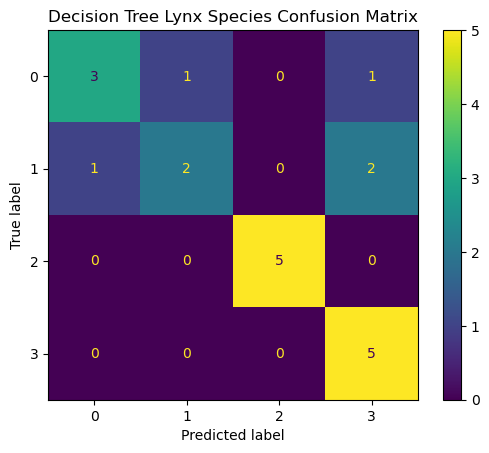

In [58]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.title('Decision Tree Lynx Species Confusion Matrix')
plt.show()

#### Neural Network

Load the trained model

In [59]:
nn_lynx_species_model = keras.models.load_model('felid_data_cache/lynx_species_nn_model')

The model produced a training validation accuracy of 94.8% and a training validation set loss of 0.145%

In [60]:
nn_lynx_species_training_accuracy = pd.read_csv('felid_data_cache/lynx_species_nn_training_accuracy.csv')
nn_lynx_species_training_accuracy = nn_lynx_species_training_accuracy.T

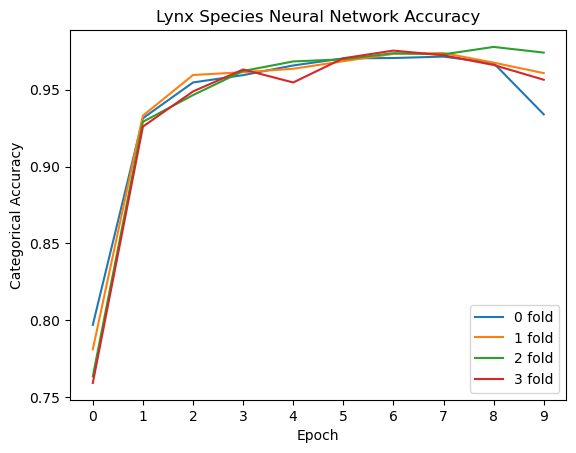

In [61]:
for i in range(nn_lynx_species_training_accuracy.shape[1]):
    plt.plot(nn_lynx_species_training_accuracy[i], label=(str(i) + ' fold'))

    
plt.title('Lynx Species Neural Network Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()

##### Load the Validation Dataset

In [62]:
nn_lynx_species_df_val = pd.read_csv('felid_data_cache/lynx_species_nn_validation.csv', index_col=0)

In [63]:
X_val, y_val, lb = prep_nn_validationSet(nn_lynx_species_df_val, 'taxon_species_name')

In [64]:
y_pred = np.argmax(nn_lynx_species_model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)

1/1 [==============================] - 0s 44ms/step


In [65]:
cm = confusion_matrix(y_true, y_pred)

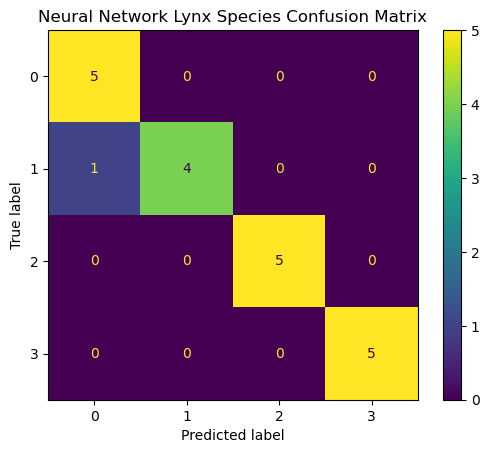

In [66]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.title('Neural Network Lynx Species Confusion Matrix')
plt.show()

### Caracal

In [67]:
caracal_df = df[df['taxon_genus_name'] == 'Caracal']

In [68]:
caracal_counts = caracal_df['taxon_species_name'].value_counts()
print(caracal_counts)

Caracal caracal    521
Caracal aurata      19
Name: taxon_species_name, dtype: int64


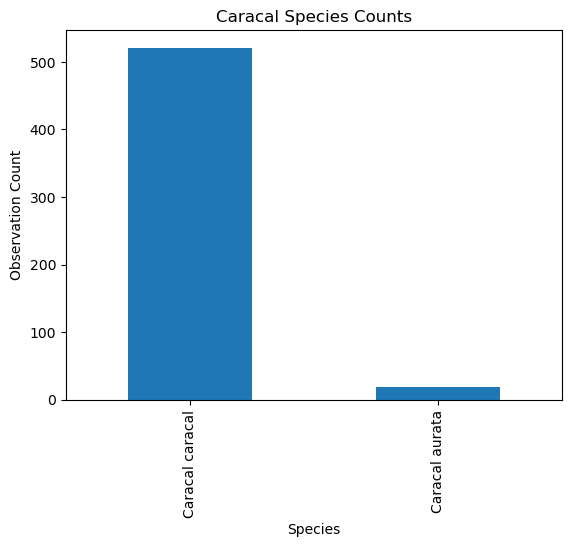

In [69]:
caracal_counts.plot(kind='bar')

plt.title('Caracal Species Counts')
plt.xlabel('Species')
plt.ylabel('Observation Count')
plt.show()

#### Geographic Distribution

/tmp/ipykernel_137969/2720374833.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))


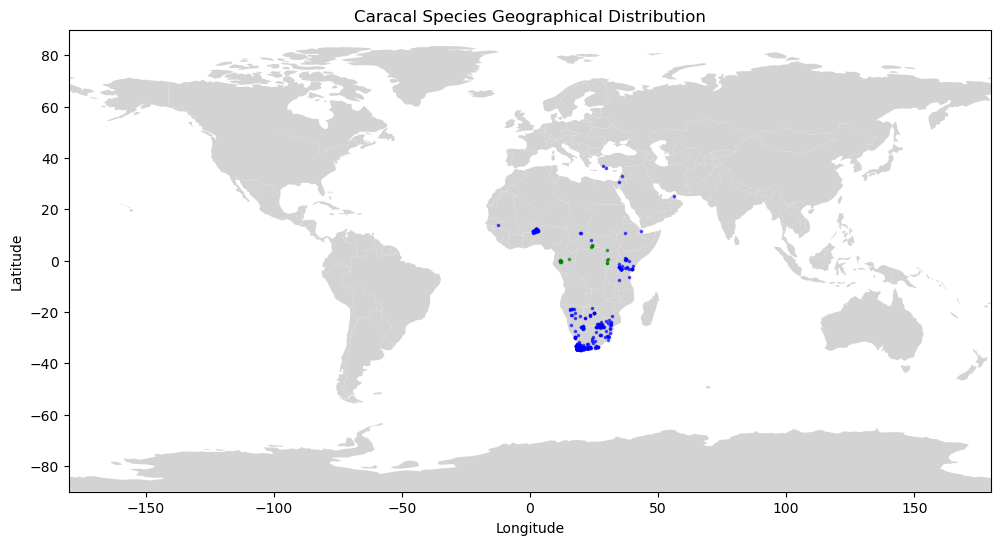

In [70]:
worldmap = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

fig, ax = plt.subplots(figsize=(12, 6))
worldmap.plot(color="lightgrey", ax=ax)


# Caracal caracal
cara_df = caracal_df[caracal_df['taxon_species_name'] == 'Caracal caracal']
cara_x = cara_df['longitude']
cara_y = cara_df['latitude']

# Caracal aurata
aurata_df = caracal_df[caracal_df['taxon_species_name'] == 'Caracal aurata']
aurata_x = aurata_df['longitude']
aurata_y = aurata_df['latitude']


# Scatter plots
scatter = plt.scatter(cara_x, cara_y, s=2.5, alpha=0.6, c='blue', label='Caracal cara')
scatter = plt.scatter(aurata_x, aurata_y, s=2.5, alpha=0.6, c='green', label='Caracal aurata')

# Creating axis limits and title
plt.xlim([-180, 180])
plt.ylim([-90, 90])

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Caracal Species Geographical Distribution")

plt.show()

#### Decision Tree

In [71]:
dt_caracal_species_training_accuracy = pd.read_csv('felid_data_cache/caracal_species_dt_training_accuracy.csv')

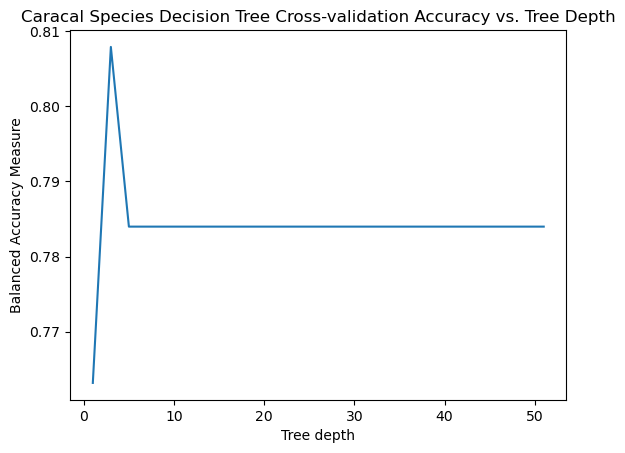

In [72]:
plt.plot(dt_caracal_species_training_accuracy['depth'], 
         dt_caracal_species_training_accuracy['mean_scores'], label='balanced accuracy')

plt.title('Caracal Species Decision Tree Cross-validation Accuracy vs. Tree Depth')
plt.xlabel('Tree depth')
plt.ylabel('Balanced Accuracy Measure')
plt.show()

In [73]:
# Model import
dt_caracal_species_model = pickle.load(open('felid_data_cache/caracal_species_dt_model.sav', 'rb'))

# Validation set
dt_caracal_species_df_val = pd.read_csv('felid_data_cache/caracal_species_dt_validation.csv', index_col=0)
X_val, y_val = prep_dt_validationSet(dt_caracal_species_df_val, 'taxon_species_name')

# Validation predictions
y_pred = dt_caracal_species_model.predict(X_val)
y_true = y_val

# Confusion matrix
cm = confusion_matrix(y_val, y_pred)

/home/travisdawson/anaconda3/envs/data_analysis/lib/python3.10/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.2.0 when using version 1.1.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


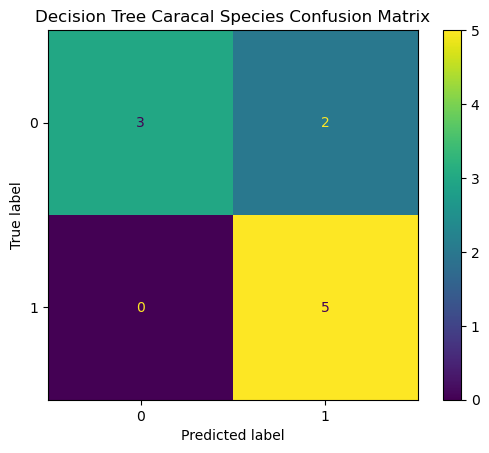

In [74]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.title('Decision Tree Caracal Species Confusion Matrix')
plt.show()

#### Neural Network

In [75]:
nn_caracal_species_model = keras.models.load_model('felid_data_cache/caracal_species_nn_model')

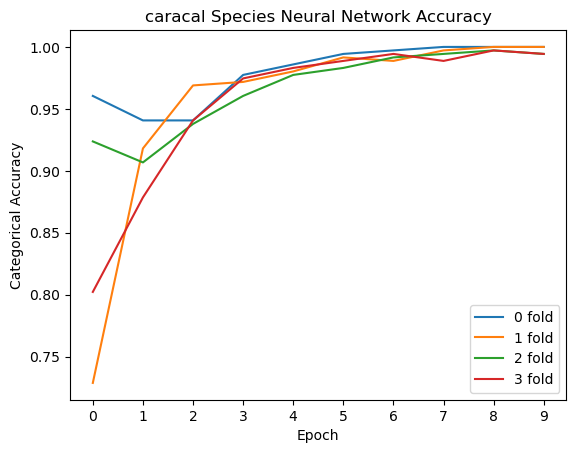

In [76]:
nn_caracal_species_training_accuracy = pd.read_csv('felid_data_cache/caracal_species_nn_training_accuracy.csv')
nn_caracal_species_training_accuracy = nn_caracal_species_training_accuracy.T

# Visualize
for i in range(nn_caracal_species_training_accuracy.shape[1]):
    plt.plot(nn_caracal_species_training_accuracy[i], label=(str(i) + ' fold'))

    
plt.title('caracal Species Neural Network Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Categorical Accuracy')
plt.legend()
plt.show()

In [77]:
# Validation dataset
nn_caracal_species_df_val = pd.read_csv('felid_data_cache/caracal_species_nn_validation.csv', index_col=0)

# Validation dataset split
X_val, y_val, lb = prep_nn_validationSet(nn_caracal_species_df_val, 'taxon_species_name')

# True and predicted labels
y_pred = np.argmax(nn_caracal_species_model.predict(X_val), axis=1)
y_true = np.argmax(y_val, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

1/1 [==============================] - 0s 42ms/step


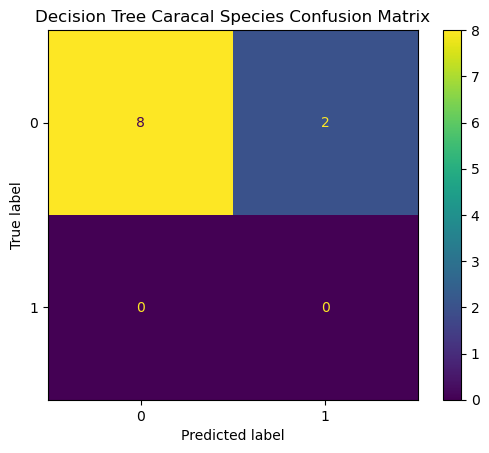

In [78]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.title('Decision Tree Caracal Species Confusion Matrix')
plt.show()